In [ ]:
# !pip install pymap2d
# !pip install shapely

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import project
from CMap2D import CMap2D, gridshow
import imageio as Image
import glob
from scipy.spatial.transform import Rotation as R
import os
from scipy.special import softmax
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from PIL import Image as image

## Loading poses with localization (tf_echo map -> camera_link)

In [2]:
path_input = "../Results/Poses_Results/TF_with_localization/map_camera.txt"
path_output = "../Results/Poses_Results/TF_with_localization/map_camera_parsed.txt"

project.parse_pose_from_TF(path_input, path_output)
poses_TF_localization = pd.read_csv(path_output)

In [3]:
poses_TF_localization.head(5)

,Time,X,Y,Z,Roll,Pitch,Yaw
0,8603.967,0.89,-1.286,0.235,-0.0,-0.0,-2.156
1,8604.967,0.89,-1.286,0.235,-0.0,-0.0,-2.156
2,8605.968,0.89,-1.286,0.235,0.0,0.0,-2.157
3,8606.967,0.89,-1.287,0.235,-0.0,0.0,-2.156
4,8607.967,0.89,-1.288,0.235,-0.0,0.0,-2.156


### Load the occupancy grid and visualise the poses on the occupancy grid to see the trajectory of robot

Loading map definition from ../Results/Map/rtabmap.yaml
Map definition found. Loading map from ../Results/Map/rtabmap.pgm
(195, 2)
map origin spatial: [-5.53812 -5.47738]
origin ij: [[0 0]]


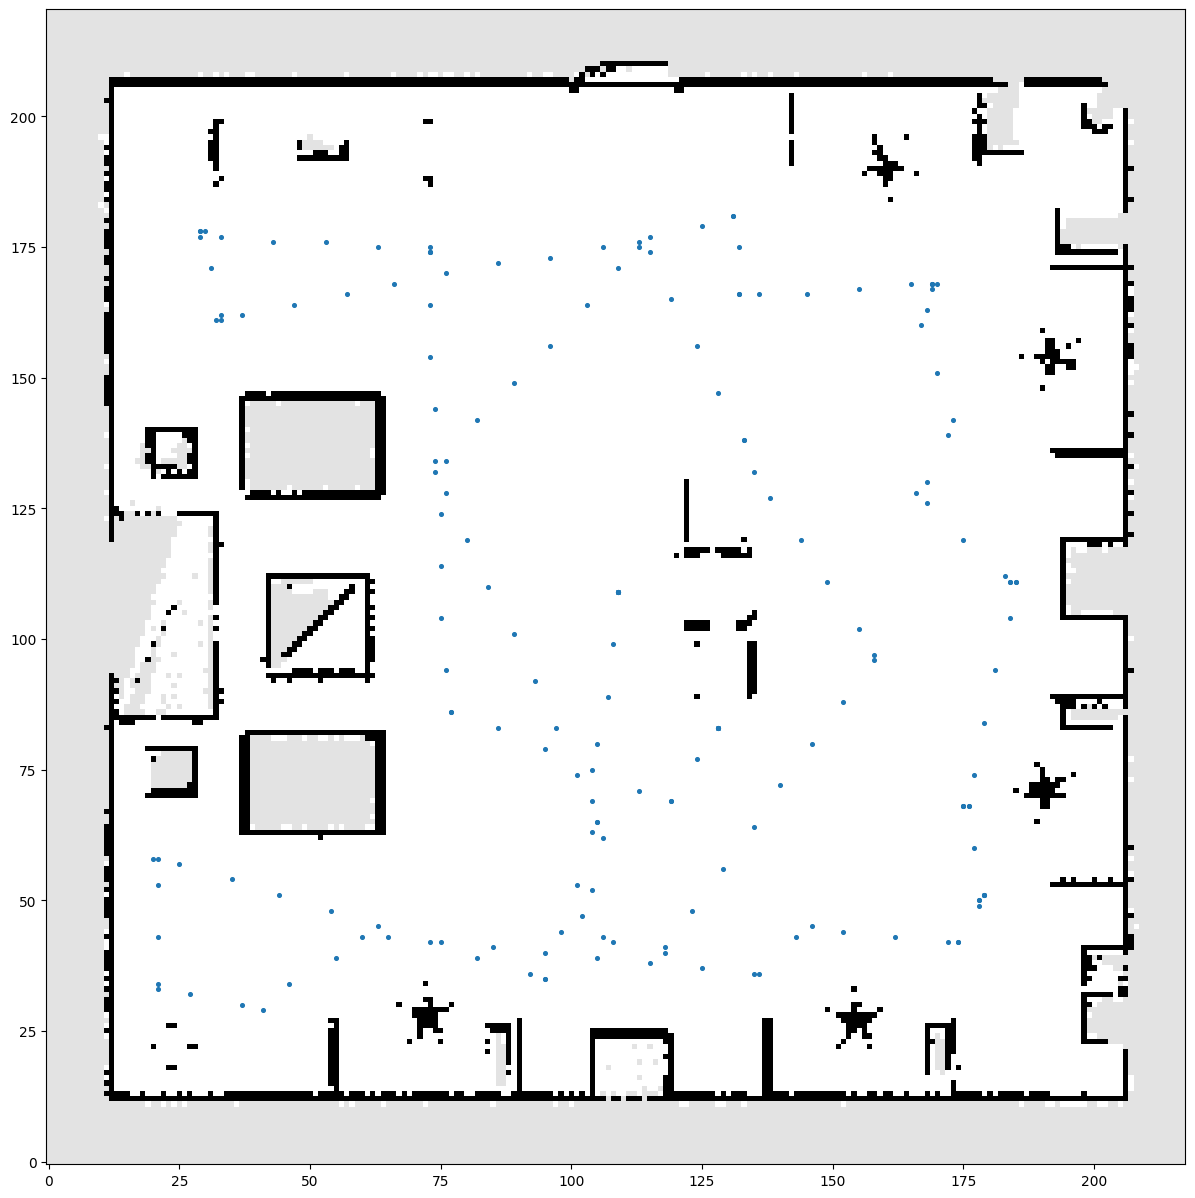

In [4]:
map = CMap2D("../Results/Map", "rtabmap")
occ_grid = map.occupancy()
origin = map.origin_xy()
x = poses_TF_localization['X']
y = poses_TF_localization['Y']
positions = np.zeros((x.shape[0],2))
print(positions.shape)
positions[:,0] = x
positions[:,1] = y
ij_positions = map.xy_to_ij(positions)
plt.figure(figsize=(15,15))
gridshow(occ_grid, cmap='Greys')
plt.scatter(ij_positions[:,0], ij_positions[:,1], s=7, )
print("map origin spatial:", origin)

origin_ij = map.xy_to_ij(origin.reshape(1,-1))
print("origin ij:", origin_ij)


### Load an rgb image and create the array of pixel coordinates

In [5]:
img = Image.v2.imread("../Results/RGBD/segment/8603.168000.jpg")

pixels = np.zeros((img.shape[1]*img.shape[0], 3), int)
count = 0
for i in range(img.shape[1]):
    for j in range(img.shape[0]):
        pixels[count, :] = [i,j,1]
        count +=1

### initialise the values for camera intrinsic matrix

In [6]:
K = np.array([554.3827128226441, 0.0, 320.5, 0.0, 554.3827128226441, 240.5, 0.0, 0.0, 1.0])
# camera intrinsic matrix
K = K.reshape(3,3)
K_inv = np.linalg.inv(K)

### Convert the pixel coordinates into camera rgb frame. 
(Currently the coordinates in this frame will be in canonical frame. we need to bring this into optical frame which is the camera frame)

In [7]:
camera_rgb_frame = (np.matmul(K_inv, pixels.T)).T # dimension [n,3]

### create matrix of depth values for all the images

In [8]:
depth_dir = '../Results/RGBD/depth/*.png'
depth_images = sorted(glob.glob(depth_dir))

z = np.zeros((len(depth_images), pixels.shape[0], 1))
for i in range(z.shape[0]):
    depth = Image.v2.imread(depth_images[i])
    for j in range(z.shape[1]):
        z[i,j,0] = depth[int(pixels[j,1]), int(pixels[j,0])] / 1000
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194


### Create function to make homogenous transformation matrix

In [9]:
def homogenous(roll, pitch, yaw, translation):
    rotation = R.from_euler('xyz', [roll, pitch, yaw])
    rotation = rotation.as_matrix()
    # translation = -np.matmul(rotation, translation)
    homogeneous_matrix = np.eye(4)
    homogeneous_matrix[:3, :3] = rotation
    homogeneous_matrix[:3, 3:] = translation

    return homogeneous_matrix

### Create function to plot the map with the transformed point coordinates

In [10]:
def plot_scatter(i, ij_positions, poses,map_frame):
    global depth_images
    r = 20
    plt.figure(figsize=(15,15))
    gridshow(occ_grid)

    dx = r * np.cos(poses['Yaw'][i])
    dy = r * np.sin(poses['Yaw'][i])
    x = ij_positions[i,0]
    y = ij_positions[i,1]

    name = os.path.basename(depth_images[i])
    plt.scatter(map_frame[:,1], map_frame[:, 0], s=25, c= 'b')
    plt.arrow(x, y, dx, dy, width=1, ec='r', fc='g')
    plt.scatter(x, y, s=25 , c='r')
    plt.savefig("../Results/plots/{}".format(name))
    plt.close()

### create matrix of transformation from canonical frame to optical frame

In [11]:
roll = -1.571
pitch = 0.00
yaw = -1.571
translation = np.array([[0.00, 0.00, 0.00]]).T
H = homogenous(roll, pitch, yaw, translation)

### create matrix of tranformation matrix from camera frame to map frame

In [12]:
n_r_t = np.zeros((poses_TF_localization.shape[0], 4, 4))
for i in range(poses_TF_localization.shape[0]):
    tx = poses_TF_localization['X'][i]
    ty = poses_TF_localization['Y'][i]
    tz = poses_TF_localization['Z'][i]
    translation = np.array([[tx, ty, tz]]).T
    roll = poses_TF_localization['Roll'][i]
    pitch = poses_TF_localization['Pitch'][i]
    yaw = poses_TF_localization['Yaw'][i]
    n_r_t[i] = homogenous(roll, pitch, yaw, translation)


### Final loop
We first multiply the pixel coordinates with the corresponding depth values associated with the image.

Then convert these coordinates which are currently in canonical frame into optical frame / camera frame.

Then convert these coordinates from the optical frame into the map frame. 

In [ ]:
mask = False
for i in range(z.shape[0]):
    zi = z[i]
    
    #multiply depth
    camera_rgb_frame_z = (camera_rgb_frame * zi)
    
    #convert camera_rgb_frame into homogenous dimension
    ones = np.ones((z.shape[1],1))
    camera_rgb_frame_homo = np.column_stack((camera_rgb_frame_z,ones))

    #transform from canonical frame to optical frame ie camera frame
    camera_frame = H @ camera_rgb_frame_homo.T

    #transform from camera frame to map frame
    map_frame = (n_r_t[i] @ camera_frame).T

    if(mask):
        map_height_mask = map_frame[:,2] > np.mean(map_frame[:,2])
        map_frame_masked = map_frame[map_height_mask]
        map_frame_xy = map_frame_masked[:,[0,1]]

    #convert the coordinates from spatial coordinates (x,y) to ij coordinates to plot in occupancy grid
    else:
        map_frame_xy = map_frame[:,[0,1]]
    map_frame_xy = map_frame_xy.copy(order='C')
    map_frame_floatij = map.xy_to_floatij(map_frame_xy)
    # plot_scatter(i, ij_positions, poses_TF_localization, map_frame_floatij)
    

### Create visualisation from plots

In [ ]:
images_dir  = "../Results/plots/*.png"
images = sorted(glob.glob(images_dir))
image = []
for idx,i in enumerate(images):
    img = Image.v2.imread(i)
    image.append(img)

Image.mimsave('../images/camera_motion.gif', image, fps= 10)

### Camera motion visualisation

In [ ]:
from IPython.display import Image as im
im(url='../images/camera_motion.gif')  


### Experiments (to be removed)

#### loading the labels
The labels are of the dimension  [width*height, number of label classes] .

The values are obtained from the last layer of esanet and hence are the probability gradients predicted by esanet for each label class.

In [13]:
labels_dir = "../../gradients/*.npy"
labels = sorted(glob.glob(labels_dir))

### assigning labels by adding up all the probabilities that points to the same cell or by multiplying the new probabilities for each label with its previous probability in the same cell

In [14]:
occ_grid_colorized = np.ones((occ_grid.shape[0], occ_grid.shape[1], 3), np.uint8) * 255
mask_height = True
occ_labels = {}
for i in range(z.shape[0]):
    zi = z[i]
    
    #multiply depth
    """The depth sensor has a limit of 5 meters. so in order to account for false segmentation values thet may come
    up due to this cutoff"""
    depth_mask = np.squeeze(zi <= 4.5)
    
    #depth filtered camera_rgb_frame pixel coordinates
    camera_rgb_frame_z = np.zeros_like(camera_rgb_frame)
    camera_rgb_frame_z[depth_mask] = camera_rgb_frame[depth_mask] * zi[depth_mask]
#     print(camera_rgb_frame_z)
    
    #convert camera_rgb_frame into homogenous dimension
    ones = np.ones((z.shape[1],1))
    camera_rgb_frame_homo = np.column_stack((camera_rgb_frame_z,ones))

    #transform from canonical frame to optical frame ie camera frame
    camera_frame = H @ camera_rgb_frame_homo.T

    #transform from camera frame to map frame
    map_frame = (n_r_t[i] @ camera_frame).T
    
    # Filtering out all the points that are outside a range of optical axis height
    if(mask_height):
        map_height_mask = (map_frame[:,2] <= 0.6675) & (map_frame[:,2] >= 0.0)
        map_frame_masked = map_frame[map_height_mask]
        map_frame_xy = map_frame_masked[:,[0,1]]

        # print(np.unique(map_frame_xy))
        # print(map_frame_xy.shape)
        
    #convert the coordinates from spatial coordinates (x,y) to ij coordinates to plot in occupancy grid
    else:
        map_frame_xy = map_frame[:,[0,1]]
    map_frame_xy = map_frame_xy.copy(order='C')
    map_frame_ij = map.xy_to_ij(map_frame_xy)
    mask = occ_grid[map_frame_ij[:,0], map_frame_ij[:,1]] == 1
    
    label = np.load(labels[i])
    for j in range(map_frame_ij.shape[0]):

        if(mask[j]):
            key = f"key_{map_frame_ij[j,0]}_{map_frame_ij[j,1]}"
        
            if (key in occ_labels):
                # multiplying probabilities
                '''since the probabilities are for the same pixel, i am considering the old probability as A and new 
                probability as B and  considering these two as dependent probabilities. 
                Now the probability of A and B is: P(A & B) =  P(A) * P(B). 
                So now probability of A given the new probability B is :
                P(A|B) = P(A & B) / P(B)'''
               
                prob_A = occ_labels[key]
                prob_B = label[j]
                prob_A_and_B = [old_label * new_label for old_label, new_label in zip(occ_labels[key] , label[j])]
                prob_A_given_B = [prob_a_and_b / prob_b for prob_a_and_b, prob_b in zip(prob_A_and_B, prob_B)]
                occ_labels[key] = prob_A_given_B
                
                # adding probabilities
#                 occ_labels[key]= [old_label + new_label for old_label, new_label in zip(occ_labels[key] , label[j])]
#                 print(np.sum(occ_labels[key]))
#                 prob_sum = np.sum(occ_labels[key])
                # print(prob_sum)
#                 occ_labels[key] = [probability / prob_sum for probability in occ_labels[key]]
 
            else:
                occ_labels[key] = label[j]
                
                
#         for key in occ_labels.keys():
#             occ_labels[key] = softmax(occ_labels[key])
    
    print(i)
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194


### Creating set of colors for the labels

In [15]:
import random
random.seed(1)
def get_random_colors(num_colors):
    colors = []
    for _ in range(num_colors):
        r = random.randint(0, 255)
        g = random.randint(0, 255)
        b = random.randint(0, 255)
        colors.append((r, g, b))
    return colors

def plot_colors(colors, label_names):
    num_colors = len(colors)
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.set_xlim(0, num_colors)
    ax.set_ylim(0, 1)
    ax.set_yticks([])

    for i, color in enumerate(colors):
        # label = str(i)
        normalized_color = (color[0] / 255, color[1] / 255, color[2] / 255)  # Normalize to range [0, 1]
        ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=normalized_color))
        ax.text(i + 0.5, 0.5, label_names[i], color='white', ha='center', va='center', fontsize=12, rotation=90)

    plt.savefig("sunrgbd_color_labels.png")
    plt.show()



#### SUNRGBD

In [16]:
num_labels = 37
label_names = ['wall',
  'floor',
  'cabinet',
  'bed',
  'chair',
  'sofa',
  'table',
  'door',
  'window',
  'bookshelf',
  'picture',
  'counter',
  'blinds',
  'desk',
  'shelves',
  'curtain',
  'dresser',
  'pillow',
  'mirror',
  'floor_mat',
  'clothes',
  'ceiling',
  'books',
  'fridge',
  'tv',
  'paper',
  'towel',
  'shower_curtain',
  'box',
  'whiteboard',
  'person',
  'night_stand',
  'toilet',
  'sink',
  'lamp',
  'bathtub',
  'bag']
unique_colors = get_random_colors(num_labels)

### assigning label to occupancy grid based on the highest probability

In [17]:
for i in range(occ_grid_colorized.shape[0]):
    for j in range(occ_grid_colorized.shape[1]):
        key = f'key_{i}_{j}'
        if(key in occ_labels):
            values = occ_labels[key]
            values = softmax(values)
            label_id = np.argmax(values)
            occ_grid_colorized[i,j] = unique_colors[label_id]

### plotting the colorized occupancy grid

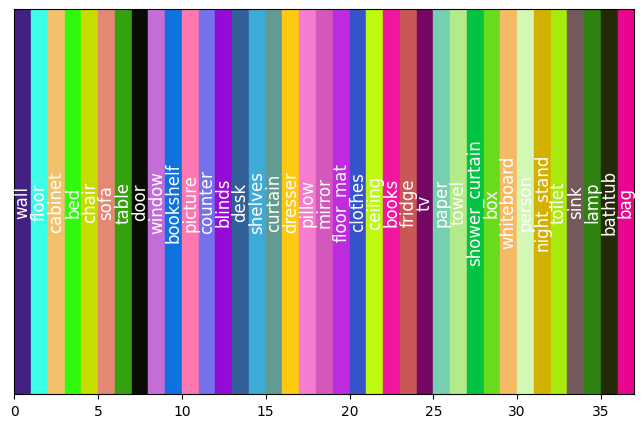

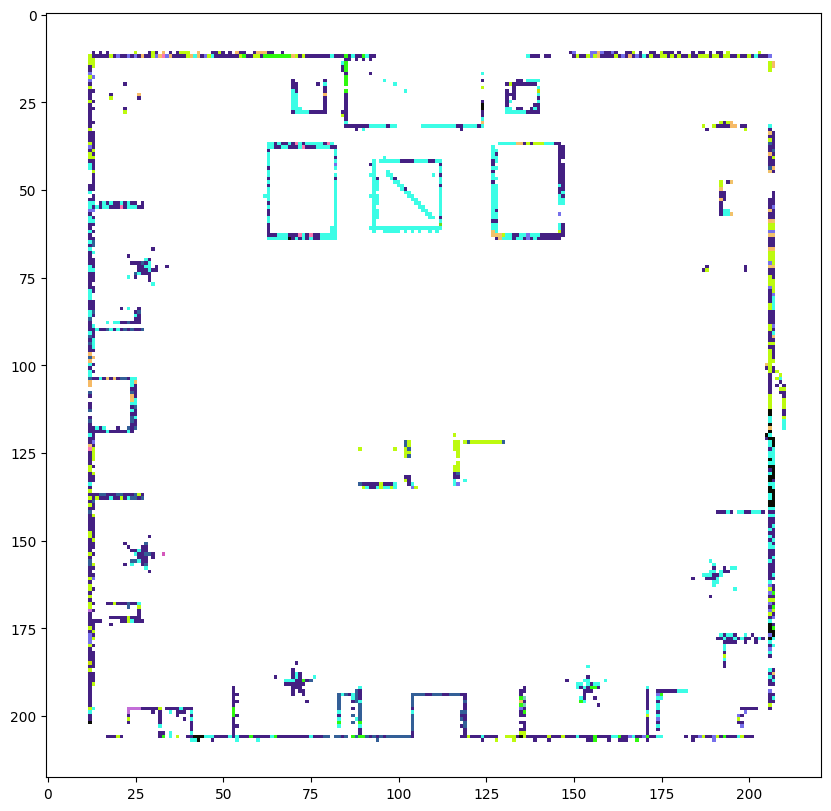

In [20]:
plot_colors(unique_colors, label_names)
plt.figure(figsize=(10,10))
# plt.imsave("../Results/seg_map/sunrgbd_seg_map_dependent_probs_real_size.png",occ_grid_colorized)
plt.imshow(occ_grid_colorized)
# plt.savefig("../Results/seg_map/sunrgbd_seg_map_dependent_probs_real_size.png")

### create new occupancy_grid

In [32]:
occ_grid_new = np.zeros((occ_grid_colorized.shape[0], occ_grid_colorized.shape[1]))
mask = occ_grid_colorized[:,:,:] == [255,255,255]
mask = mask[:,:,0]
occ_grid_new[~mask] = 1 

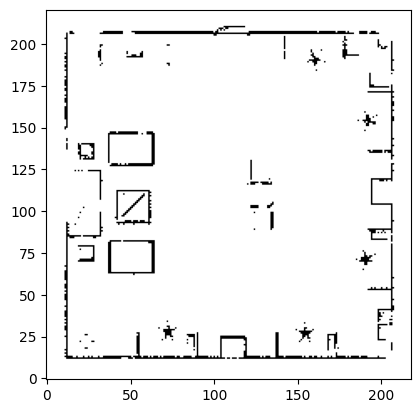

In [34]:
new_map = CMap2D()
new_map.from_array(occ_grid_new, map.origin_xy(), map.resolution())
new_occ_grid = new_map.occupancy()
gridshow(new_occ_grid)

### Assign labels to cells by most occuring label

In [ ]:
occ_grid_colorized = np.ones((occ_grid.shape[0], occ_grid.shape[1], 3), np.uint8) * 255
mask_height = False
occ_labels = {}
for i in range(z.shape[0]):
    zi = z[i]
    
    #multiply depth
    camera_rgb_frame_z = (camera_rgb_frame * zi)
    
    #convert camera_rgb_frame into homogenous dimension
    ones = np.ones((z.shape[1],1))
    camera_rgb_frame_homo = np.column_stack((camera_rgb_frame_z,ones))

    #transform from canonical frame to optical frame ie camera frame
    camera_frame = H @ camera_rgb_frame_homo.T

    #transform from camera frame to map frame
    map_frame = (n_r_t[i] @ camera_frame).T
    # print((np.min(map_frame[:,2]) + np.max(map_frame[:,2]) / 2))
    if(mask_height):
        map_height_mask = (map_frame[:,2] <= 0.145) & (map_frame[:,2] >= 0.125)
        map_frame_masked = map_frame[map_height_mask]
        map_frame_xy = map_frame_masked[:,[0,1]]

        # print(np.unique(map_frame_xy))
        # print(map_frame_xy.shape)
    #convert the coordinates from spatial coordinates (x,y) to ij coordinates to plot in occupancy grid
    else:
        map_frame_xy = map_frame[:,[0,1]]
    map_frame_xy = map_frame_xy.copy(order='C')
    map_frame_ij = map.xy_to_ij(map_frame_xy)
    mask = occ_grid[map_frame_ij[:,0], map_frame_ij[:,1]] == 1
    
    # for j in range(occ_grid_colorized[map_frame_ij[:, 0], map_frame_ij[:, 1], :].shape[0]):
    #     if(mask[j].all()):
    #         # print(map_frame_ij[j, 0], map_frame_ij[j, 1])
    #         occ_grid_colorized[map_frame_ij[j, 0], map_frame_ij[j, 1], :] = labels[i,j,:]
    label = np.load(labels[i])
    # print(label.shape)
    for j in range(map_frame_ij.shape[0]):

        if(mask[j]):
            key = f"key_{map_frame_ij[j,0]}_{map_frame_ij[j,1]}"

            if (key in occ_labels):
                occ_labels[key]= np.vstack((occ_labels[key], np.argmax(label[j])))
            else:
                # print(np.argmax(label[j]))
                occ_labels[key] = np.argmax(label[j])
    print(i)

In [ ]:
for i in range(occ_grid_colorized.shape[0]):
    for j in range(occ_grid_colorized.shape[1]):
        key = f'key_{i}_{j}'
        if(key in occ_labels):
            values = occ_labels[key]
            unique_labels, count = np.unique(values, return_counts=True)
            unique_idx = np.argmax(count)
            unique_label = unique_labels[unique_idx]
            # print(unique_label)
            occ_grid_colorized[i, j, :] = unique_colors[unique_label]

In [ ]:
plot_colors(unique_colors, label_names)
plt.figure(figsize=(10,10))
plt.imshow(occ_grid_colorized)
plt.savefig("../Results/seg_map/seg_map_max_count.png")

### Viewing the polygon contours in the occupancy grid

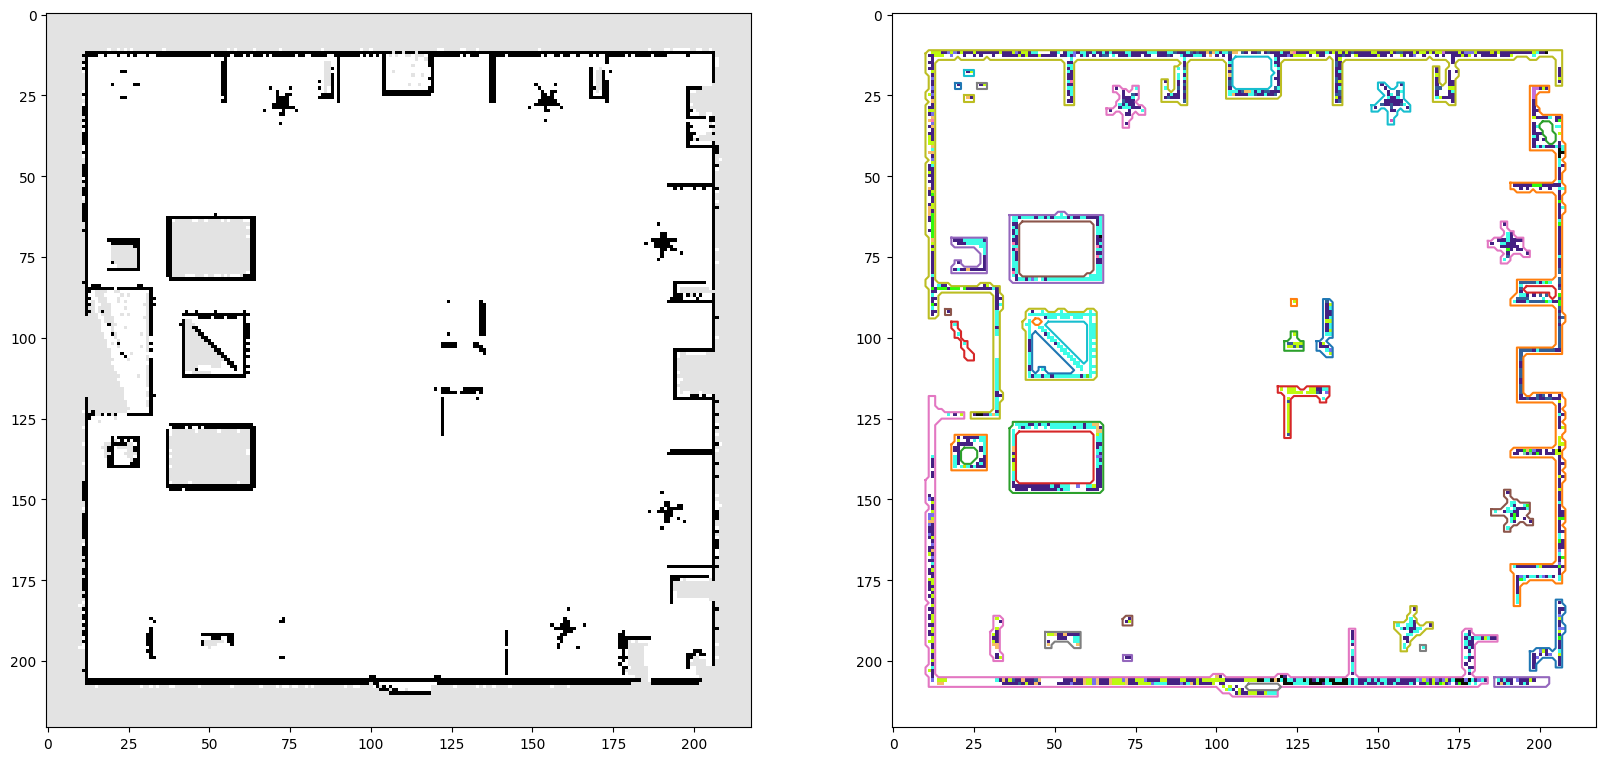

In [47]:
contours = map.as_closed_obst_vertices_ij()
plt.figure(figsize=(20,10))

plt.subplot(1, 2, 1) 
plt.imshow(np.transpose(occ_grid, (1,0)), cmap='Greys')

plt.subplot(1, 2, 2)
plt.imshow(np.transpose(occ_grid_colorized, (1,0,2)))
polygons = []

for c in contours:
    poly = Polygon(c)
    polygons.append(poly)
    plt.plot(*poly.exterior.xy)

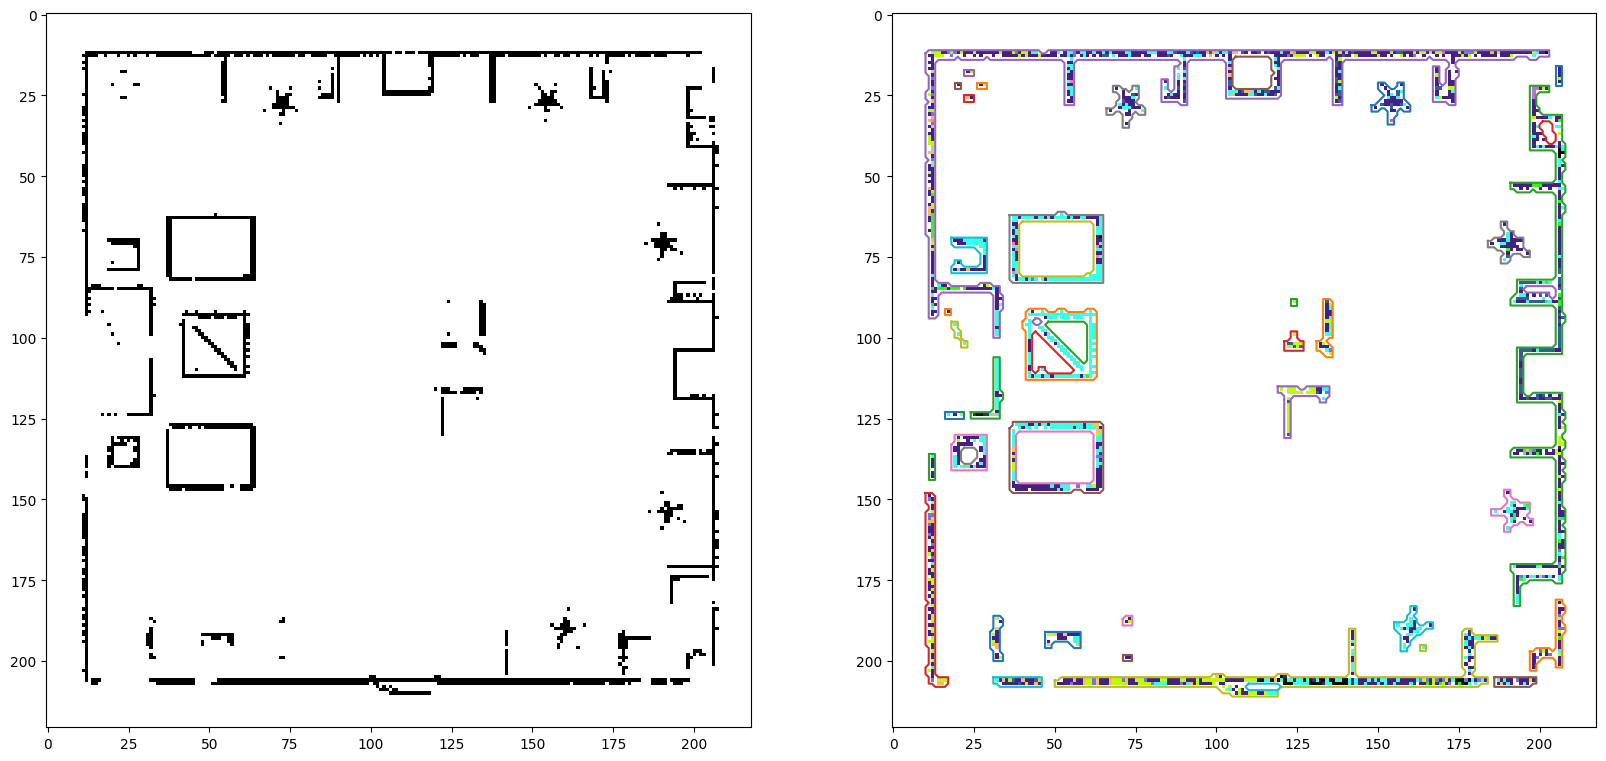

In [48]:
contours = new_map.as_closed_obst_vertices_ij()
plt.figure(figsize=(20,10))
# gridshow(occ_grid_new)

plt.subplot(1, 2, 1) 
plt.imshow(np.transpose(occ_grid_new, (1,0)), cmap='Greys')

plt.subplot(1, 2, 2)
plt.imshow(np.transpose(occ_grid_colorized, (1,0,2)))

polygons = []
for c in contours:
    poly = Polygon(c)
    polygons.append(poly)
    plt.plot(*poly.exterior.xy)

In [49]:
# occ_grid_poly_colorized = np.transpose(occ_grid_colorized,(1,0,2))
occ_grid_poly_colorized = np.ones_like(occ_grid_colorized) *255
occ_labels_in_poly = {}


### labels based on polygon

created a new dictionary to save all the labels for a given polygon (contour of occupancies) 

In [50]:

for i in range(occ_grid_poly_colorized.shape[0]):
    for j in range(occ_grid_poly_colorized.shape[1]):
        keyij = f'key_{i}_{j}'
        point = Point(np.array([[i,j]]))
        if keyij in occ_labels:
            for idx,polygon in enumerate(polygons):
                key = f'{idx}'
                
                if (point.within(polygon)):
                    if key in occ_labels_in_poly:
#                         print(f'labels: {len(occ_labels[keyij])}')
                        occ_labels_in_poly[key] = np.vstack((occ_labels_in_poly[key],occ_labels[keyij]))
                    else:
#                         print(f'labels: {len(occ_labels[keyij])}')
                        occ_labels_in_poly[key] = np.array(occ_labels[keyij]).reshape([1,-1])
                        
        

In [51]:
occ_labels_in_poly.keys()

dict_keys(['44', '43', '42', '41', '40', '39', '38', '36', '35', '34', '33', '32', '31', '30', '29', '27', '25', '21', '20', '18', '17', '16', '15', '14', '13', '12', '11', '10', '9', '8', '7', '6', '5', '2', '1', '0'])

In [52]:
occ_labels_in_poly['38'].shape

(3, 37)

### assigning global label for a given polygon
assumption is a polygon will represent a single object

### method
using the method of dependent probabilities for a given polygon

In [53]:
for key in occ_labels_in_poly:
    print(f'key: {key}')
    values =occ_labels_in_poly[key]
    print(f'number of observations in polygon: {len(values)}')
#     break
#     print(len(values))
    temp_label = []
    value = values[0,:]
    for i in range(1,values.shape[0]):
        prob_A = value
        prob_B = values[i,:]
        prob_A_and_B = [A * B for A,B in zip(prob_A, prob_B)] 
        value = prob_A_and_B / prob_B 
        
    value = softmax(value)    
    poly_label = np.argmax(value)
    print(f'polygon label: {poly_label}')
    occ_labels_in_poly[key] = poly_label

key: 44
number of observations in polygon: 630
polygon label: 0
key: 43
number of observations in polygon: 91
polygon label: 0
key: 42
number of observations in polygon: 6
polygon label: 1
key: 41
number of observations in polygon: 1
polygon label: 0
key: 40
number of observations in polygon: 3
polygon label: 1
key: 39
number of observations in polygon: 38
polygon label: 0
key: 38
number of observations in polygon: 3
polygon label: 1
key: 36
number of observations in polygon: 50
polygon label: 0
key: 35
number of observations in polygon: 1
polygon label: 0
key: 34
number of observations in polygon: 2
polygon label: 0
key: 33
number of observations in polygon: 2
polygon label: 29
key: 32
number of observations in polygon: 26
polygon label: 0
key: 31
number of observations in polygon: 2
polygon label: 0
key: 30
number of observations in polygon: 16
polygon label: 21
key: 29
number of observations in polygon: 26
polygon label: 1
key: 27
number of observations in polygon: 129
polygon label

In [54]:
for i in range(occ_grid_poly_colorized.shape[0]):
    for j in range(occ_grid_poly_colorized.shape[1]):
        keyij = f'key_{i}_{j}'
        point = Point(np.array([[i,j]]))
        if keyij in occ_labels:
            for idx,polygon in enumerate(polygons):
                key = f'{idx}'
                if (point.within(polygon)):
                    occ_grid_poly_colorized[i, j, :] = unique_colors[occ_labels_in_poly[key]]
            

In [55]:
occ_grid_poly_colorized.shape

(218, 221, 3)

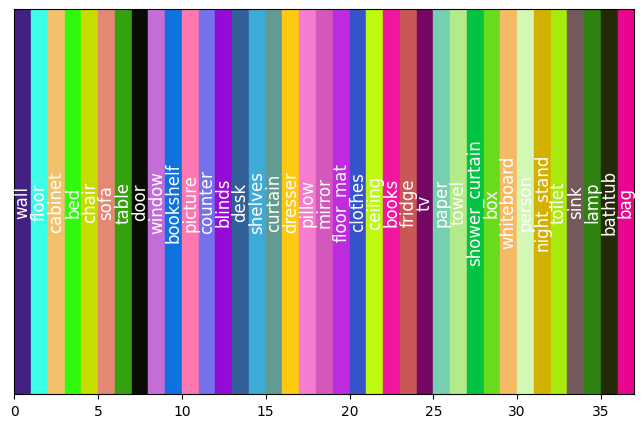

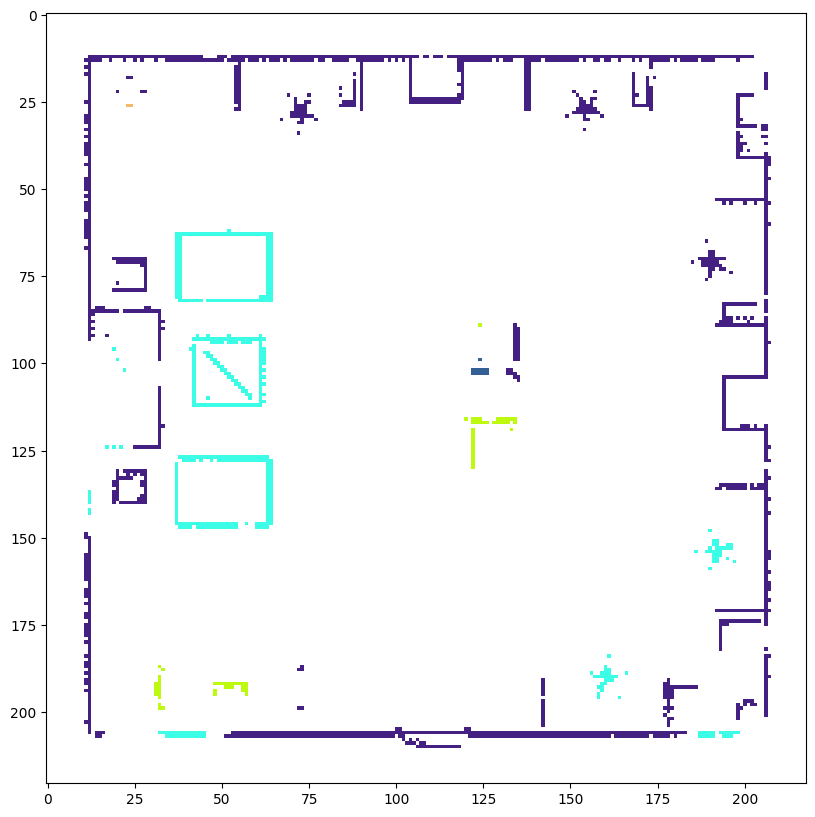

In [57]:
plot_colors(unique_colors, label_names)
plt.figure(figsize=(10,10))
plt.imshow(np.transpose(occ_grid_poly_colorized, (1,0,2)))
plt.imsave('../Results/seg_map/sunrgbd_seg_map_polygon_label_wo_polygons_non_transposed.png', occ_grid_poly_colorized)
# for c in contours:
#     poly = Polygon(c)
#     polygons.append(poly)
#     plt.plot(*poly.exterior.xy)

# plt.savefig('../Results/seg_map/sunrgbd_seg_map_polygon_label_wo_polygons.png')

### Annotation

In [39]:
# load chairs mask

chairs1 = '../Results/masks/chairs1_mask.png'
chairs = np.array(image.open(chairs1))

bookshelf = '../Results/masks/bookshelf_mask.png'
bookshelf = np.array(image.open(bookshelf))

cabinet = '../Results/masks/cabinets_mask.png'
cabinet = np.array(image.open(cabinet))

door = '../Results/masks/door_mask.png'
door = np.array(image.open(door))

dresser = '../Results/masks/dresser1_mask.png'
dresser = np.array(image.open(dresser))

nightstand = '../Results/masks/nightstand_mask.png'
nightstand = np.array(image.open(nightstand))

small_table = '../Results/masks/small_tables_mask.png'
small_table = np.array(image.open(small_table))

small_table2 = '../Results/masks/small_tables2_mask.png'
small_table2 = np.array(image.open(small_table2))

sofas = '../Results/masks/sofas_mask.png'
sofas = np.array(image.open(sofas))

tables1 = '../Results/masks/tables1_mask.png'
tables1 = np.array(image.open(tables1))

tables2 = '../Results/masks/tables2_mask.png'
tables2 = np.array(image.open(tables2))

tables3 = '../Results/masks/tables3_mask.png'
tables3 = np.array(image.open(tables3))

tables4 = '../Results/masks/tables4_mask.png'
tables4 = np.array(image.open(tables4))

tables5 = '../Results/masks/tables5_mask.png'
tables5 = np.array(image.open(tables5))

tables6 = '../Results/masks/tables6_mask.png'
tables6 = np.array(image.open(tables6))

desks = tables1 + tables2 + tables3 + tables4 + tables5 + tables6
tables = small_table + small_table2

trashcan = '../Results/masks/trashcan_mask.png'
trashcan = np.array(image.open(trashcan))

walls = '../Results/masks/walls_mask.png'
walls = np.array(image.open(walls))


In [43]:
def create_mask(array):
    array_ = array.reshape(-1, array.shape[2])              
    counter, counts = np.unique(array_, axis=0, return_counts=True)
    min_count_idx = np.argmin(counts)
    
    print(counter[min_count_idx][0])
    print(counts)
    print(counter)

    array_mask = (array[:,:,0] == counter[min_count_idx][0]) 
    return array_mask

chairs_mask = create_mask(chairs)
desks_mask = create_mask(desks)
bookshelf_mask = create_mask(bookshelf)
door_mask = create_mask(door)
cabinet_mask = create_mask(cabinet)
dresser_mask = create_mask(dresser)
nightstand_mask = create_mask(nightstand)
tables_mask = create_mask(tables)
sofas_mask = create_mask(sofas)
trashcan_mask = create_mask(trashcan)
walls_mask = create_mask(walls)

253
[40904  7274]
[[ 68   1  84 255]
 [253 231  36 255]]
81
[ 1498 46680]
[[ 81 236 200 250]
 [152   6 248 250]]
253
[48006   172]
[[ 68   1  84 255]
 [253 231  36 255]]
253
[47973   205]
[[ 68   1  84 255]
 [253 231  36 255]]
253
[48081    97]
[[ 68   1  84 255]
 [253 231  36 255]]
253
[45944  2234]
[[ 68   1  84 255]
 [253 231  36 255]]
253
[47990   188]
[[ 68   1  84 255]
 [253 231  36 255]]
253
[46683  1495]
[[ 68   1  84 255]
 [253 231  36 255]]
253
[45180  2998]
[[ 68   1  84 255]
 [253 231  36 255]]
253
[48133    45]
[[ 68   1  84 255]
 [253 231  36 255]]
253
[41500  6678]
[[ 68   1  84 255]
 [253 231  36 255]]


### assigning labels

In [45]:
gt = np.ones_like(occ_grid_colorized)*255
gt[:,:,0:3][chairs_mask] = unique_colors[4]
gt[:,:,0:3][desks_mask] = unique_colors[13]
gt[:,:,0:3][bookshelf_mask] = unique_colors[9]
gt[:,:,0:3][door_mask] = unique_colors[7]
gt[:,:,0:3][cabinet_mask] = unique_colors[2]
gt[:,:,0:3][dresser_mask] = unique_colors[16]
gt[:,:,0:3][nightstand_mask] = unique_colors[31]
gt[:,:,0:3][tables_mask] = unique_colors[6]
gt[:,:,0:3][sofas_mask] = unique_colors[5]
gt[:,:,0:3][trashcan_mask] = unique_colors[28]
gt[:,:,0:3][walls_mask] = unique_colors[0]

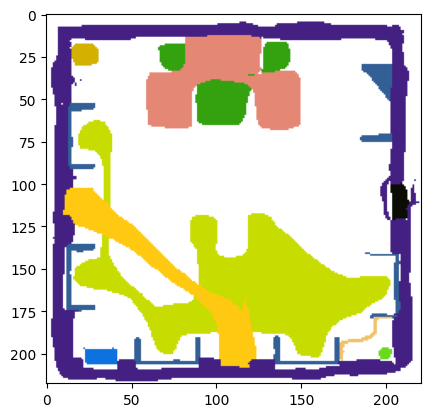

In [46]:
plt.imshow(gt)

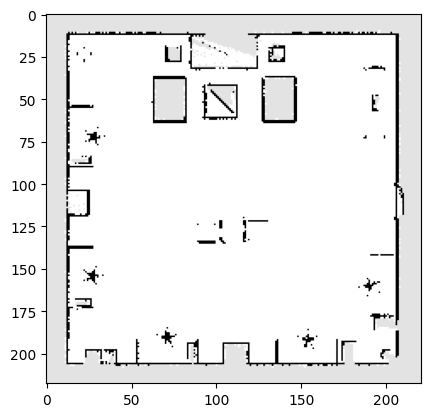

In [48]:
plt.imshow(occ_grid, cmap='Greys')

### Creating groundtruth

In [49]:
for i in range(gt.shape[0]):
    for j in range(gt.shape[1]):
        
        if(occ_grid[i,j] != 1.0):
            gt[i,j,:] = 255

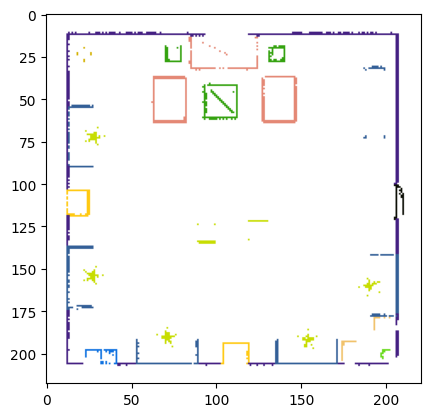

In [50]:
plt.imshow(gt)

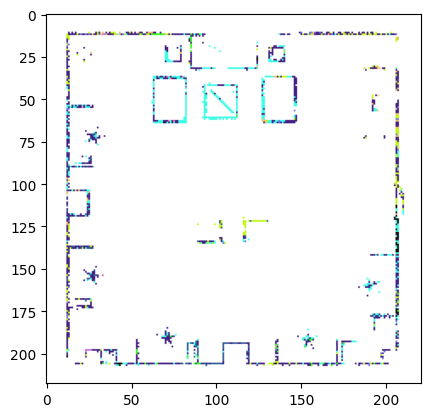

In [51]:
plt.imshow(occ_grid_colorized)

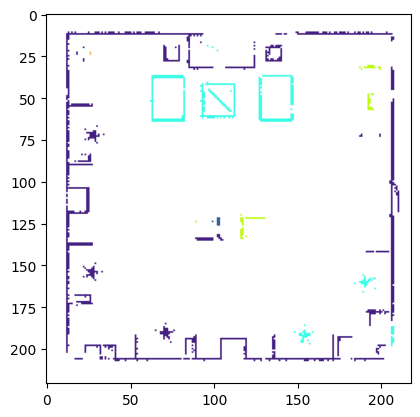

In [52]:
plt.imshow(occ_grid_poly_colorized)

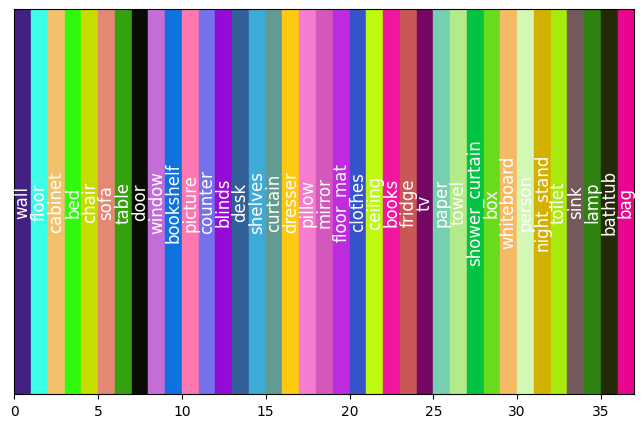

In [53]:
plot_colors(unique_colors, label_names)

### calculate iou and miou

##### non polygon filtered

In [55]:

def calculate_iou(gt_image, test_image, labels):
    global label_names
    iou_sum = 0.0
    num_labels = len(labels)
    iou = []
    for label in range(len(labels)):
#         intersection = np.sum((gt_image[:,:,0] == labels[label]) & (test_image == labels[label]))
#         union = np.sum((gt_image == labels[label]) | (test_image == labels[label]))
        intersection = np.sum((gt_image[:, :, 0] == labels[label][0]) & 
                         (gt_image[:, :, 1] == labels[label][1]) & 
                         (gt_image[:, :, 2] == labels[label][2]) &
                         (test_image[:, :, 0] == labels[label][0]) & 
                         (test_image[:, :, 1] == labels[label][1]) & 
                         (test_image[:, :, 2] == labels[label][2]))
        union = np.sum((gt_image[:, :, 0] == labels[label][0]) | 
                   (gt_image[:, :, 1] == labels[label][1]) | 
                   (gt_image[:, :, 2] == labels[label][2]) |
                   (test_image[:, :, 0] == labels[label][0]) | 
                   (test_image[:, :, 1] == labels[label][1]) | 
                   (test_image[:, :, 2] == labels[label][2]))
        if union == 0:
            lab_iou = np.nan
            print(f"label: {label_names[label]} \n iou: {lab_iou} \n union: {union} pixels \n intersection: {intersection} pixels")
            iou.append(lab_iou)  # Treat as 100% IoU if the union is empty
        else:
            lab_iou = intersection / union
            print(f"label: {label_names[label]} \n iou: {lab_iou} \n union: {union} pixels \n intersection: {intersection} pixels")
            iou.append(lab_iou)
    
   
    return iou, np.nanmean(iou)



# Example usage
# Assuming gt_image and test_image are numpy arrays with pixel-wise labels
gt_image = gt[:,:,0:3]
test_image = occ_grid_colorized
iou, miou = calculate_iou(gt_image, test_image, unique_colors)
# calculate_miou(gt_image, test_image, unique_colors)
# miou = calculate_miou(gt_image, test_image, unique_colors)

# print(f"IoU: {iou}")
# print(f"mIoU: {miou}")

label: wall 
 iou: 0.22774193548387098 
 union: 1550 pixels 
 intersection: 353 pixels
label: floor 
 iou: 0.0 
 union: 582 pixels 
 intersection: 0 pixels
label: cabinet 
 iou: 0.0 
 union: 61 pixels 
 intersection: 0 pixels
label: bed 
 iou: 0.0 
 union: 46 pixels 
 intersection: 0 pixels
label: chair 
 iou: 0.0 
 union: 192 pixels 
 intersection: 0 pixels
label: sofa 
 iou: 0.0 
 union: 360 pixels 
 intersection: 0 pixels
label: table 
 iou: 0.0 
 union: 441 pixels 
 intersection: 0 pixels
label: door 
 iou: 0.06097560975609756 
 union: 82 pixels 
 intersection: 5 pixels
label: window 
 iou: 0.0 
 union: 6 pixels 
 intersection: 0 pixels
label: bookshelf 
 iou: 0.0 
 union: 50 pixels 
 intersection: 0 pixels
label: picture 
 iou: 0.0 
 union: 10 pixels 
 intersection: 0 pixels
label: counter 
 iou: 0.0 
 union: 60 pixels 
 intersection: 0 pixels
label: blinds 
 iou: nan 
 union: 0 pixels 
 intersection: 0 pixels
label: desk 
 iou: 0.06355140186915888 
 union: 535 pixels 
 intersecti

In [56]:
print(iou)
print(f"label with highest iou: {label_names[np.nanargmax(iou)]}")

[0.22774193548387098, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06097560975609756, 0.0, 0.0, 0.0, 0.0, nan, 0.06355140186915888, 0.0, nan, 0.0, nan, 0.0, 0.0, nan, 0.0, nan, nan, 0.0, 0.0, nan, nan, 0.0, 0.0, nan, 0.0, 0.0, nan, nan, nan, nan]
label with highest iou: wall


In [57]:
print(miou)

0.014677872796213643


#### polygon filtered

(218, 221, 3)


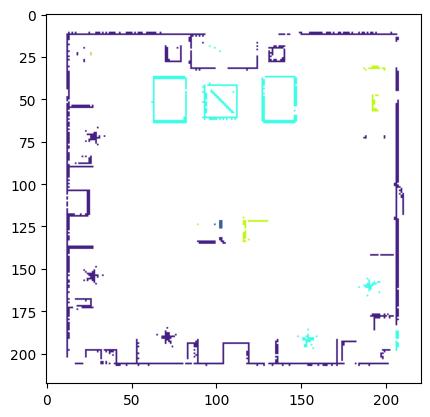

In [74]:
print(occ_grid_poly_colorized.shape)
plt.imshow(occ_grid_poly_colorized)

(218, 221, 3)


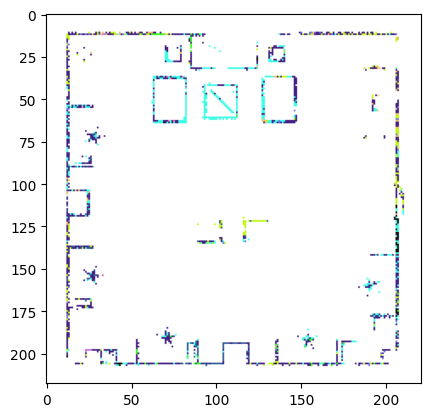

In [75]:
print(occ_grid_colorized.shape)
plt.imshow(occ_grid_colorized)

In [76]:
test_image = occ_grid_poly_colorized
iou, miou = calculate_iou(gt_image, test_image, unique_colors)

label: wall 
 iou: 0.36120218579234975 
 union: 1830 pixels 
 intersection: 661 pixels
label: floor 
 iou: 0.0 
 union: 479 pixels 
 intersection: 0 pixels
label: cabinet 
 iou: 0.0 
 union: 35 pixels 
 intersection: 0 pixels
label: bed 
 iou: nan 
 union: 0 pixels 
 intersection: 0 pixels
label: chair 
 iou: 0.0 
 union: 190 pixels 
 intersection: 0 pixels
label: sofa 
 iou: 0.0 
 union: 360 pixels 
 intersection: 0 pixels
label: table 
 iou: 0.0 
 union: 289 pixels 
 intersection: 0 pixels
label: door 
 iou: 0.0 
 union: 46 pixels 
 intersection: 0 pixels
label: window 
 iou: nan 
 union: 0 pixels 
 intersection: 0 pixels
label: bookshelf 
 iou: 0.0 
 union: 50 pixels 
 intersection: 0 pixels
label: picture 
 iou: nan 
 union: 0 pixels 
 intersection: 0 pixels
label: counter 
 iou: nan 
 union: 0 pixels 
 intersection: 0 pixels
label: blinds 
 iou: nan 
 union: 0 pixels 
 intersection: 0 pixels
label: desk 
 iou: 0.0 
 union: 463 pixels 
 intersection: 0 pixels
label: shelves 
 iou: 

In [78]:
print(iou)
print(f"label with highest iou: {label_names[np.nanargmax(iou)]}")
print(f"miou: {miou}|")

[0.36120218579234975, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, nan, 0.0, nan, 0.0, 0.0, nan, 0.0, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, nan, nan]
label with highest iou: wall
miou: 0.021247187399549984|


## NYUV2

40


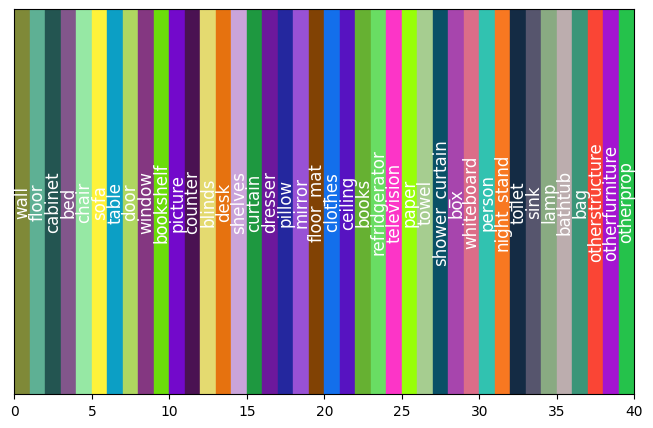

In [79]:
# import scipy.io as sio
# labls = sio.loadmat('/home/ajay/work/msc_project/git/nyuv2_labels/classMapping40.mat')
# for i in (labls['className']):
#     print(i)
    
num_labels = 40
label_names = ['wall',
  'floor',
  'cabinet',
  'bed',
  'chair',
  'sofa',
  'table',
  'door',
  'window',
  'bookshelf',
  'picture',
  'counter',
  'blinds',
  'desk',
  'shelves',
  'curtain',
  'dresser',
  'pillow',
  'mirror',
  'floor_mat',
  'clothes',
  'ceiling',
  'books',
  'refridgerator',
  'television',
  'paper',
  'towel',
  'shower_curtain',
  'box',
  'whiteboard',
  'person',
  'night_stand',
  'toilet',
  'sink',
  'lamp',
  'bathtub',
  'bag',
  'otherstructure',
  'otherfurniture',
  'otherprop']
print(len(label_names))
unique_colors = get_random_colors(num_labels)
plot_colors(unique_colors, label_names)

In [80]:
labels_dir = "/media/ajay/Backup Plus/Uni Bonn/msc_project/gradients/nyuv2/*.npy"
labels = sorted(glob.glob(labels_dir))

In [81]:
occ_grid_colorized = np.ones((occ_grid.shape[0], occ_grid.shape[1], 3), np.uint8) * 255
mask_height = True
occ_labels = {}
for i in range(z.shape[0]):
    zi = z[i]
    
    #multiply depth
    """The depth sensor has a limit of 5 meters. so in order to account for false segmentation values thet may come
    up due to this cutoff"""
    depth_mask = np.squeeze(zi <= 4.5)
    
    #depth filtered camera_rgb_frame pixel coordinates
    camera_rgb_frame_z = np.zeros_like(camera_rgb_frame)
    camera_rgb_frame_z[depth_mask] = camera_rgb_frame[depth_mask] * zi[depth_mask]
#     print(camera_rgb_frame_z)
    
    #convert camera_rgb_frame into homogenous dimension
    ones = np.ones((z.shape[1],1))
    camera_rgb_frame_homo = np.column_stack((camera_rgb_frame_z,ones))

    #transform from canonical frame to optical frame ie camera frame
    camera_frame = H @ camera_rgb_frame_homo.T

    #transform from camera frame to map frame
    map_frame = (n_r_t[i] @ camera_frame).T
    
    # Filtering out all the points that are outside a range of optical axis height
    if(mask_height):
        map_height_mask = (map_frame[:,2] <= 0.6675) & (map_frame[:,2] >= 0.0)
        map_frame_masked = map_frame[map_height_mask]
        map_frame_xy = map_frame_masked[:,[0,1]]

        # print(np.unique(map_frame_xy))
        # print(map_frame_xy.shape)
        
    #convert the coordinates from spatial coordinates (x,y) to ij coordinates to plot in occupancy grid
    else:
        map_frame_xy = map_frame[:,[0,1]]
    map_frame_xy = map_frame_xy.copy(order='C')
    map_frame_ij = map.xy_to_ij(map_frame_xy)
    mask = occ_grid[map_frame_ij[:,0], map_frame_ij[:,1]] == 1
    
    label = np.load(labels[i])
    for j in range(map_frame_ij.shape[0]):

        if(mask[j]):
            key = f"key_{map_frame_ij[j,0]}_{map_frame_ij[j,1]}"
        
            if (key in occ_labels):
                # multiplying probabilities
                '''since the probabilities are for the same pixel, i am considering the old probability as A and new 
                probability as B and  considering these two as dependent probabilities. 
                Now the probability of A and B is: P(A & B) =  P(A) * P(B). 
                So now probability of A given the new probability B is :
                P(A|B) = P(A & B) / P(B)'''
               
                prob_A = occ_labels[key]
                prob_B = label[j]
                prob_A_and_B = [old_label * new_label for old_label, new_label in zip(occ_labels[key] , label[j])]
                prob_A_given_B = [prob_a_and_b / prob_b for prob_a_and_b, prob_b in zip(prob_A_and_B, prob_B)]
                occ_labels[key] = prob_A_given_B
                
                # adding probabilities
#                 occ_labels[key]= [old_label + new_label for old_label, new_label in zip(occ_labels[key] , label[j])]
#                 print(np.sum(occ_labels[key]))
#                 prob_sum = np.sum(occ_labels[key])
                # print(prob_sum)
#                 occ_labels[key] = [probability / prob_sum for probability in occ_labels[key]]
 
            else:
                occ_labels[key] = label[j]
                
                
#         for key in occ_labels.keys():
#             occ_labels[key] = softmax(occ_labels[key])
    
    print(i)
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194


In [82]:
for i in range(occ_grid_colorized.shape[0]):
    for j in range(occ_grid_colorized.shape[1]):
        key = f'key_{i}_{j}'
        if(key in occ_labels):
            values = occ_labels[key]
            values = softmax(values)
            label_id = np.argmax(values)
            occ_grid_colorized[i,j] = unique_colors[label_id]

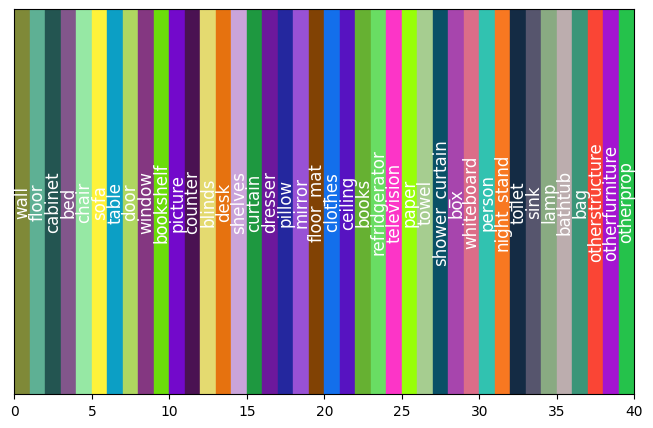

<Figure size 100x100 with 0 Axes>

In [83]:
plot_colors(unique_colors, label_names)
plt.figure(figsize=(1,1))
plt.imsave("../Results/seg_map/nyuv2_seg_map_dependent_probs_real_size.png",occ_grid_colorized)
# plt.savefig("../Results/seg_map/sunrgbd_seg_map_dependent_probs_real_size.png")

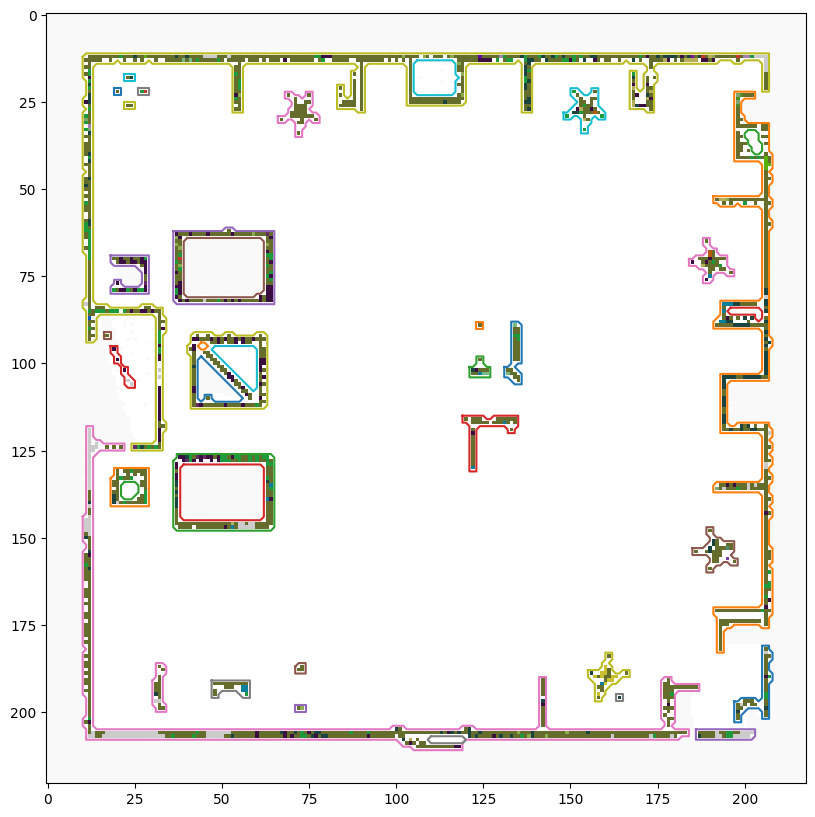

In [84]:
contours = map.as_closed_obst_vertices_ij()
plt.figure(figsize=(10,10))
gridshow(occ_grid)
plt.imshow(np.transpose(occ_grid_colorized, (1,0,2)), alpha=0.8)
polygons = []
for c in contours:
    poly = Polygon(c)
    polygons.append(poly)
    plt.plot(*poly.exterior.xy)

In [85]:
# occ_grid_poly_colorized = np.transpose(occ_grid_colorized,(1,0,2))
occ_grid_poly_colorized = np.ones_like(occ_grid_colorized) *255
occ_labels_in_poly = {}


In [86]:

for i in range(occ_grid_poly_colorized.shape[0]):
    for j in range(occ_grid_poly_colorized.shape[1]):
        keyij = f'key_{i}_{j}'
        point = Point(np.array([[i,j]]))
        if keyij in occ_labels:
            for idx,polygon in enumerate(polygons):
                key = f'{idx}'
                
                if (point.within(polygon)):
                    if key in occ_labels_in_poly:
#                         print(f'labels: {len(occ_labels[keyij])}')
                        occ_labels_in_poly[key] = np.vstack((occ_labels_in_poly[key],occ_labels[keyij]))
                    else:
#                         print(f'labels: {len(occ_labels[keyij])}')
                        occ_labels_in_poly[key] = np.array(occ_labels[keyij]).reshape([1,-1])
                        
        

In [87]:
for key in occ_labels_in_poly:
    print(f'key: {key}')
    values =occ_labels_in_poly[key]
    print(f'number of observations in polygon: {len(values)}')
#     break
#     print(len(values))
    temp_label = []
    value = values[0,:]
    for i in range(1,values.shape[0]):
        prob_A = value
        prob_B = values[i,:]
        prob_A_and_B = [A * B for A,B in zip(prob_A, prob_B)] 
        value = prob_A_and_B / prob_B 
        
    value = softmax(value)    
    poly_label = np.argmax(value)
    print(f'polygon label: {poly_label}')
    occ_labels_in_poly[key] = poly_label

key: 38
number of observations in polygon: 661
polygon label: 0
key: 36
number of observations in polygon: 436
polygon label: 0
key: 35
number of observations in polygon: 1
polygon label: 0
key: 34
number of observations in polygon: 38
polygon label: 0
key: 33
number of observations in polygon: 3
polygon label: 11
key: 31
number of observations in polygon: 50
polygon label: 0
key: 30
number of observations in polygon: 1
polygon label: 0
key: 29
number of observations in polygon: 2
polygon label: 0
key: 28
number of observations in polygon: 2
polygon label: 0
key: 27
number of observations in polygon: 2
polygon label: 39
key: 26
number of observations in polygon: 16
polygon label: 0
key: 24
number of observations in polygon: 129
polygon label: 11
key: 22
number of observations in polygon: 143
polygon label: 11
key: 18
number of observations in polygon: 129
polygon label: 0
key: 17
number of observations in polygon: 20
polygon label: 0
key: 16
number of observations in polygon: 32
polygo

In [88]:
for i in range(occ_grid_poly_colorized.shape[0]):
    for j in range(occ_grid_poly_colorized.shape[1]):
        keyij = f'key_{i}_{j}'
        point = Point(np.array([[i,j]]))
        if keyij in occ_labels:
            for idx,polygon in enumerate(polygons):
                key = f'{idx}'
                if (point.within(polygon)):
                    occ_grid_poly_colorized[i, j, :] = unique_colors[occ_labels_in_poly[key]]
            

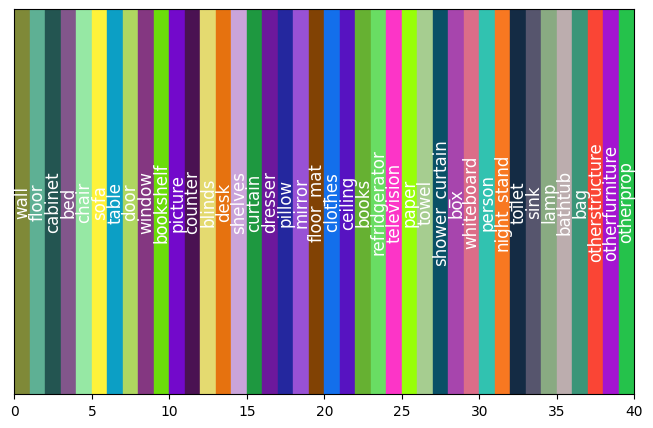

<Figure size 100x100 with 0 Axes>

In [89]:
plot_colors(unique_colors, label_names)
plt.figure(figsize=(1,1))
# plt.imshow(np.transpose(occ_grid_poly_colorized, (1,0,2)))
plt.imsave('../Results/seg_map/nyuv2_seg_map_polygon_label_wo_polygons_non_transposed.png', occ_grid_poly_colorized)
# for c in contours:
#     poly = Polygon(c)
#     polygons.append(poly)
#     plt.plot(*poly.exterior.xy)

# plt.savefig('../Results/seg_map/sunrgbd_seg_map_polygon_label_wo_polygons.png')

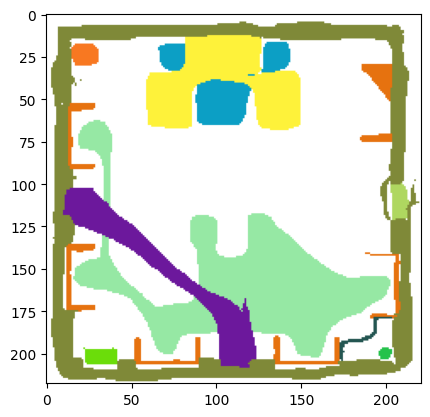

In [91]:
gt = np.ones_like(occ_grid_colorized)*255
gt[:,:,0:3][chairs_mask] = unique_colors[4]
gt[:,:,0:3][desks_mask] = unique_colors[13]
gt[:,:,0:3][bookshelf_mask] = unique_colors[9]
gt[:,:,0:3][door_mask] = unique_colors[7]
gt[:,:,0:3][cabinet_mask] = unique_colors[2]
gt[:,:,0:3][dresser_mask] = unique_colors[16]
gt[:,:,0:3][nightstand_mask] = unique_colors[31]
gt[:,:,0:3][tables_mask] = unique_colors[6]
gt[:,:,0:3][sofas_mask] = unique_colors[5]
gt[:,:,0:3][trashcan_mask] = unique_colors[39]
gt[:,:,0:3][walls_mask] = unique_colors[0]

plt.imshow(gt)

In [92]:
for i in range(gt.shape[0]):
    for j in range(gt.shape[1]):
        
        if(occ_grid[i,j] != 1.0):
            gt[i,j,:] = 255

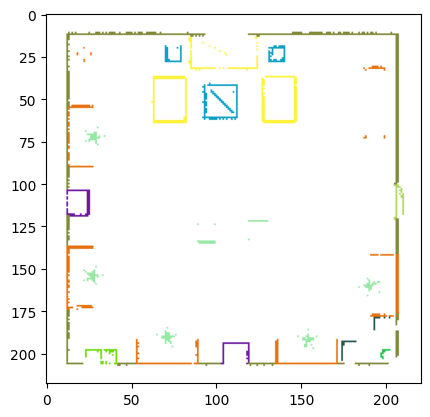

In [94]:
plt.imshow(gt)

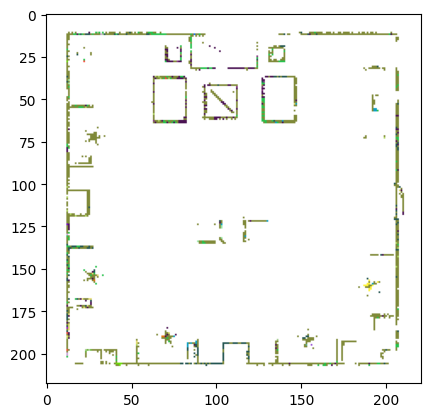

In [95]:
plt.imshow(occ_grid_colorized)

In [98]:
gt_image = gt[:,:,0:3]
test_image = occ_grid_colorized
iou, miou = calculate_iou(gt_image, test_image, unique_colors)

label: wall 
 iou: 0.26961038961038963 
 union: 1925 pixels 
 intersection: 519 pixels
label: floor 
 iou: 0.0 
 union: 1 pixels 
 intersection: 0 pixels
label: cabinet 
 iou: 0.0 
 union: 189 pixels 
 intersection: 0 pixels
label: bed 
 iou: nan 
 union: 0 pixels 
 intersection: 0 pixels
label: chair 
 iou: 0.005128205128205128 
 union: 195 pixels 
 intersection: 1 pixels
label: sofa 
 iou: 0.0 
 union: 372 pixels 
 intersection: 0 pixels
label: table 
 iou: 0.0 
 union: 236 pixels 
 intersection: 0 pixels
label: door 
 iou: 0.0 
 union: 66 pixels 
 intersection: 0 pixels
label: window 
 iou: 0.0 
 union: 7 pixels 
 intersection: 0 pixels
label: bookshelf 
 iou: 0.01818181818181818 
 union: 55 pixels 
 intersection: 1 pixels
label: picture 
 iou: 0.0 
 union: 1 pixels 
 intersection: 0 pixels
label: counter 
 iou: 0.0 
 union: 184 pixels 
 intersection: 0 pixels
label: blinds 
 iou: 0.0 
 union: 18 pixels 
 intersection: 0 pixels
label: desk 
 iou: 0.0 
 union: 455 pixels 
 intersecti

In [99]:
print(f'iou: \n {iou}')
print(f'miou: \n {miou}')

iou: 
 [0.26961038961038963, 0.0, 0.0, nan, 0.005128205128205128, 0.0, 0.0, 0.0, 0.0, 0.01818181818181818, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, 0.0, nan, 0.0, 0.0, nan, 0.0, 0.0, nan, 0.0, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, 0.0, 0.0]
miou: 
 0.010461443318586176


In [100]:
test_image = occ_grid_poly_colorized
iou, miou = calculate_iou(gt_image, test_image, unique_colors)

label: wall 
 iou: 0.34119417962870047 
 union: 1993 pixels 
 intersection: 680 pixels
label: floor 
 iou: nan 
 union: 0 pixels 
 intersection: 0 pixels
label: cabinet 
 iou: 0.0 
 union: 73 pixels 
 intersection: 0 pixels
label: bed 
 iou: nan 
 union: 0 pixels 
 intersection: 0 pixels
label: chair 
 iou: 0.0 
 union: 190 pixels 
 intersection: 0 pixels
label: sofa 
 iou: 0.0 
 union: 360 pixels 
 intersection: 0 pixels
label: table 
 iou: 0.0 
 union: 218 pixels 
 intersection: 0 pixels
label: door 
 iou: 0.0 
 union: 46 pixels 
 intersection: 0 pixels
label: window 
 iou: nan 
 union: 0 pixels 
 intersection: 0 pixels
label: bookshelf 
 iou: 0.0 
 union: 50 pixels 
 intersection: 0 pixels
label: picture 
 iou: nan 
 union: 0 pixels 
 intersection: 0 pixels
label: counter 
 iou: 0.0 
 union: 308 pixels 
 intersection: 0 pixels
label: blinds 
 iou: nan 
 union: 0 pixels 
 intersection: 0 pixels
label: desk 
 iou: 0.0 
 union: 452 pixels 
 intersection: 0 pixels
label: shelves 
 iou: 

In [101]:
print(f'iou: \n {iou}')
print(f'miou: \n {miou}')

iou: 
 [0.34119417962870047, nan, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, nan, nan, 0.0]
miou: 
 0.02132463622679378
